In [8]:
from dotenv import load_dotenv
import os

load_dotenv()
# os.environ['HF_TOKEN']

True

In [15]:
%%bash
mkdir -p data/flickr8k/
# rm -r "data/flickr8k/"

if [ ! -f "data/flickr8k.zip" ]
then
    wget "https://github.com/awsaf49/flickr-dataset/releases/download/v1.0/flickr8k.zip" -O "data/flickr8k.zip"
fi

if [ ! -d "data/flickr8k/" ]
then
    unzip "data/flickr8k.zip" -d ./data/flickr8k/
    rm data/flickr8k.zip
    echo "Downloaded Flickr8k dataset successfully."
fi


In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch" # you can also use tensorflow or torch
# import torch
import keras_cv
import keras_nlp
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)
print("KerasNLP:", keras_nlp.__version__)
# print("Torch:", torch.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2025-03-29 02:28:17.355945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743233297.408496   11204 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743233297.427315   11204 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-29 02:28:17.504301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow: 2.18.0
Keras: 3.8.0
KerasCV: 0.9.0
KerasNLP: 0.18.1


2025-03-29 02:28:27.904652: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1743233307.905025   11204 gpu_device.cc:2022] Created device /device:GPU:0 with 1402 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9372155257306663237
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1471086592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14877964523436288289
 physical_device_desc: "device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [2]:
class CFG:
    debug = False
    seed = 42
    
    image_path = "./data/flickr8k/Images"
    caption_path = "./data/flickr8k"
    
    # Training params
    batch_size = 32
    epochs = 10

    # Image Encoder
    image_preset = "efficientnetv2_b0_imagenet_classifier"
    image_size = [224, 224]
    
    # Text Encoder
    text_preset = "distil_bert_base_en"
    sequence_length = 200
    
    # For embedding head
    embedding_dim = 256
    dropout = 0.1


keras.utils.set_random_seed(CFG.seed)
df = pd.read_csv(f"{CFG.caption_path}/captions.txt")
df["image_path"] = CFG.image_path + "/" + df.image
df.head()

,image,caption,image_path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,./data/flickr8k/Images/1000268201_693b08cb0e.jpg
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,./data/flickr8k/Images/1000268201_693b08cb0e.jpg
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,./data/flickr8k/Images/1000268201_693b08cb0e.jpg
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,./data/flickr8k/Images/1000268201_693b08cb0e.jpg
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,./data/flickr8k/Images/1000268201_693b08cb0e.jpg


In [3]:
from sklearn.model_selection import GroupKFold

# Create a GroupKFold object with 5 folds
gkf = GroupKFold(n_splits=5)

# Add fold column based on groups
df['fold'] = -1
for fold, (train_index, valid_index) in enumerate(gkf.split(df, groups=df["image"])):
    df.loc[valid_index, 'fold'] = fold

df.sample(15)

,image,caption,image_path,fold
17775,2973269132_252bfd0160.jpg,A large wild cat is pursuing a horse across a ...,./data/flickr8k/Images/2973269132_252bfd0160.jpg,2
13506,270263570_3160f360d3.jpg,Two brown dogs fight on the leafy ground .,./data/flickr8k/Images/270263570_3160f360d3.jpg,1
4325,2053006423_6adf69ca67.jpg,A man in shorts is standing on a rock looking ...,./data/flickr8k/Images/2053006423_6adf69ca67.jpg,4
37870,512101751_05a6d93e19.jpg,a muzzled white dog is running on the grass .,./data/flickr8k/Images/512101751_05a6d93e19.jpg,1
21321,3156406419_38fbd52007.jpg,A person skiing downhill .,./data/flickr8k/Images/3156406419_38fbd52007.jpg,2
18798,3030823649_3b7b6c728d.jpg,Shepherd dog catches tennis ball,./data/flickr8k/Images/3030823649_3b7b6c728d.jpg,3
22799,3218861747_5c5c547b66.jpg,A skateboarder is riding on a red ramp by the ...,./data/flickr8k/Images/3218861747_5c5c547b66.jpg,1
17668,2966190737_ceb6eb4b53.jpg,Two men dressed in white hit a ball while a th...,./data/flickr8k/Images/2966190737_ceb6eb4b53.jpg,0
31017,3547000169_40191e02ca.jpg,Three men sit at the counter in a restaurant .,./data/flickr8k/Images/3547000169_40191e02ca.jpg,3
24809,3300019891_8f404d94a1.jpg,There is a large gathering of people in costum...,./data/flickr8k/Images/3300019891_8f404d94a1.jpg,3


In [4]:
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset=CFG.text_preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.10)),
        keras_cv.layers.RandomRotation(factor=(0.01, 0.05)),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp):
        inp["images"] = augmenter({"images": inp["images"]})["images"]
        return inp
    return augment

def build_decoder(target_size=CFG.image_size):
    def decode_image(image_path):
        # Read jpeg image
        file_bytes = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        return image

    def decode_text(text):
        text = preprocessor(text)
        return text

    def decode_input(image_path, text):
        image = decode_image(image_path)
        text = decode_text(text)
        return {"images":image, "texts":text}

    return decode_input


def build_dataset(
    image_paths,
    texts,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=True,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder()

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    slices = (image_paths, texts)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

I0000 00:00:1743233318.573823   11204 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1402 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1


### Playground

In [ ]:
my_df = df.groupby("image").head(1).reset_index(drop=True) # .sample(frac=1.0)
my_df = my_df[my_df.fold == 0]
my_df = my_df.head(15)

my_paths = my_df.image_path.values
my_texts = my_df.caption.values



def build_my_dataset(
    image_paths,
    texts,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=True,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder()

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    slices = (image_paths, texts)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    print(ds)
    print(list(ds.as_numpy_iterator()))
    print(type(ds))
    print(list(ds.as_numpy_iterator()))
    print(type(ds))
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    samples = list(ds.as_numpy_iterator())
    print("==============================")
    print(samples[0]['images'].size)
    print(samples[0]['images'].shape)
    print(type(samples[0]['images']))
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds

    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    print("==============================")
    print(ds)
    print(type(ds))
    samples1 = list(ds.as_numpy_iterator())
    print(samples1[0]['images'].shape)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

my_ds = build_my_dataset(my_paths, my_texts,
                         batch_size=10,
                         repeat=False, shuffle=False, augment=False, cache=True)

print("==================================")
for i,s in my_ds.enumerate():
  print(i)
  print(s.keys())
  break

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>
[(b'./data/flickr8k/Images/1000268201_693b08cb0e.jpg', b'A child in a pink dress is climbing up a set of stairs in an entry way .'), (b'./data/flickr8k/Images/1001773457_577c3a7d70.jpg', b'A black dog and a spotted dog are fighting'), (b'./data/flickr8k/Images/1009434119_febe49276a.jpg', b'A black and white dog is running in a grassy garden surrounded by a white fence .'), (b'./data/flickr8k/Images/101669240_b2d3e7f17b.jpg', b'A man in a hat is displaying pictures next to a skier in a blue hat .'), (b'./data/flickr8k/Images/1022454332_6af2c1449a.jpg', b'A child and a woman are at waters edge in a big city .'), (b'./data/flickr8k/Images/102455176_5f8ead62d5.jpg', b'A man uses ice picks and crampons to scale ice .'), (b'./data/flickr8k/Images/103195344_5d2dc613a3.jpg', b'A man in black is sitting next to a modern art structure in front of a glass buildin

2025-03-29 02:23:39.622645: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-03-29 02:23:39.639308: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


150528
(224, 224, 3)
<class 'numpy.ndarray'>
<_BatchDataset element_spec={'images': TensorSpec(shape=(10, 224, 224, 3), dtype=tf.float32, name=None), 'texts': {'token_ids': TensorSpec(shape=(10, 200), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(10, 200), dtype=tf.bool, name=None)}}>
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


2025-03-29 02:23:43.053589: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(10, 224, 224, 3)
tf.Tensor(0, shape=(), dtype=int64)
dict_keys(['images', 'texts'])


In [6]:
# Sample from full data
sample_df = df.groupby("image").head(1).reset_index(drop=True) # .sample(frac=1.0)
# train_df = sample_df[sample_df.fold != 0]
valid_df = sample_df[sample_df.fold == 0]
# print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Train
# train_paths = train_df.image_path.values
# train_texts = train_df.caption.values
# train_ds = build_dataset(train_paths, train_texts,
#                          batch_size=CFG.batch_size,
#                          repeat=True, shuffle=True, augment=True, cache=True)

# Valid
valid_paths = valid_df.image_path.values
valid_texts = valid_df.caption.values
valid_ds = build_dataset(valid_paths, valid_texts,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=True)

2025-03-29 02:29:10.359398: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.040180136..1.0000175].


[CLS] A child in a pink dress is climbing up a set of stairs in an entry way . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

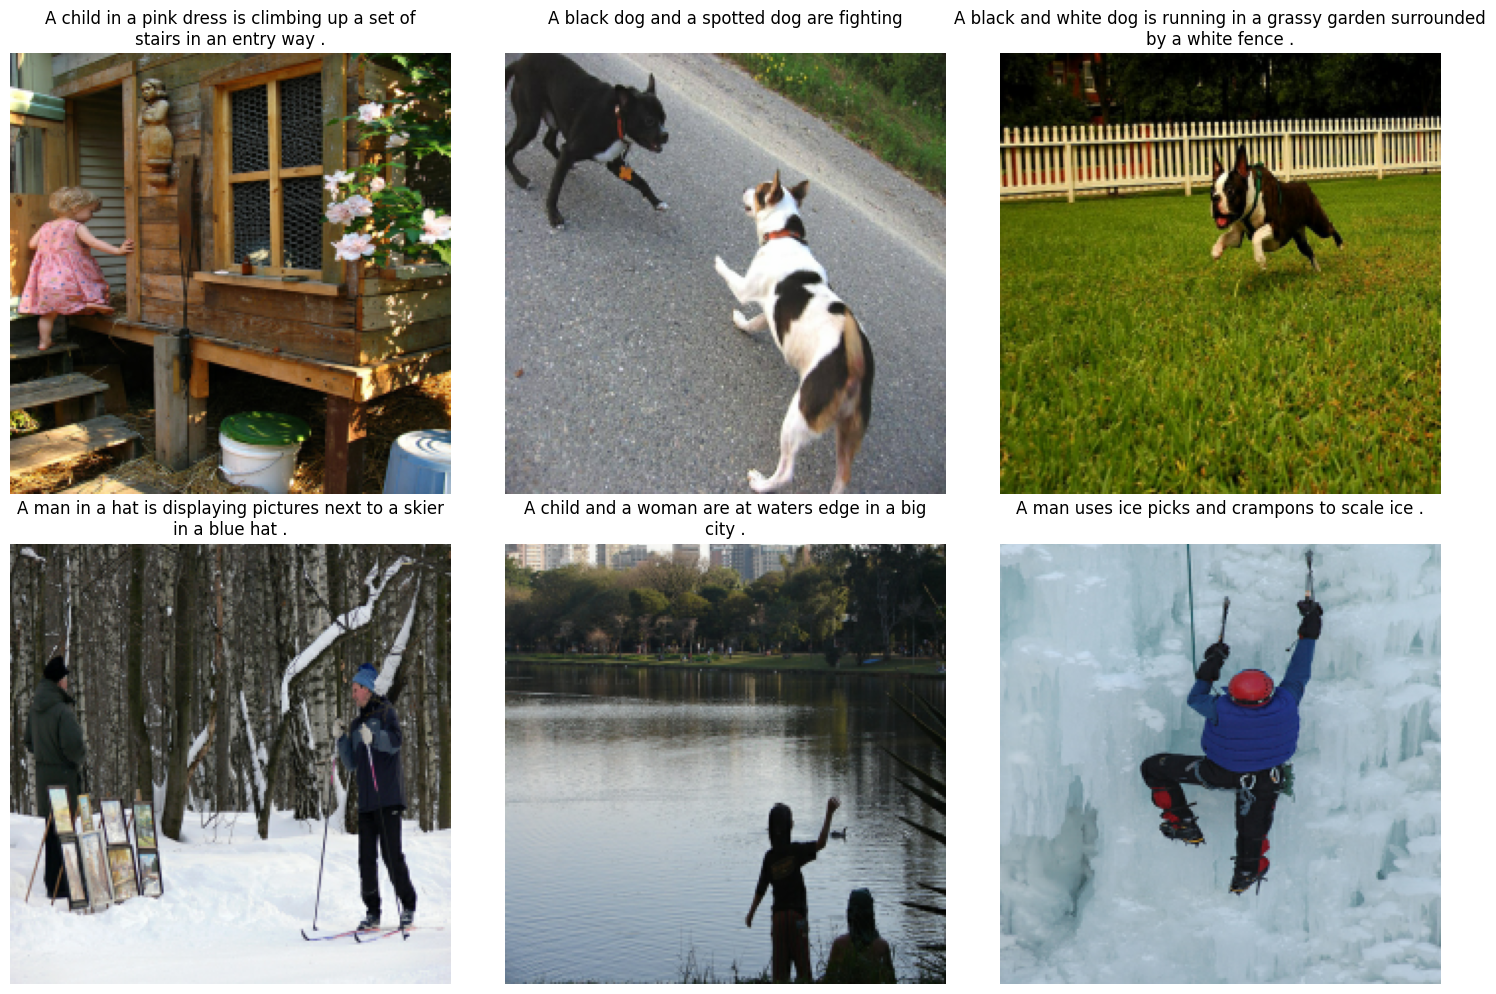

In [7]:
batch = next(iter(valid_ds))
imgs = batch["images"]
txts = batch["texts"]

fig = plt.figure(figsize=(15, 10)) 
for i in range(6):
    img = imgs[i].numpy()
    print(preprocessor.tokenizer.detokenize(txts["token_ids"][i]))
    caption = preprocessor.tokenizer.detokenize(txts["token_ids"][i])
    print(caption)
    caption = caption.replace("[PAD]","").replace("[CLS]","").replace("[SEP]","").strip()
    caption = " ".join(caption.split(" ")[:12]) + "\n" + " ".join(caption.split(" ")[12:])
    plt.subplot(2, 3, i + 1) 
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12) 

plt.tight_layout()
plt.show()

In [ ]:
class SigLIPLoss(keras.losses.Loss):
    def __init__(self, name="siglip_loss"):
        """Calculates the SigLIP loss.

        Standard sigmoid computes the loss twice, once assuming positive
        labels and once assuming negative ones. But in this case, positives
        are on the "me" diagonal and negatives are elsewhere. So, we only
        compute the loss for each once.

        Call Args:
            y_true: Ground truth labels.
            y_pred: Predicted logits.

        Returns:
            tensor: The SigLIP loss.
        """
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        # Normalize by the number of positives per column (npos), which is one.
        # Since it's one, we just sum.
        loss = -ops.sum(ops.log_sigmoid(y_true * y_pred), axis=-1)

        # NOTE: This is equivalent to concatenating "me" and "ot" along axis -1 above.
        loss = ops.mean(loss)
        return loss
    
    
class CLIPLoss(keras.losses.Loss):
    def __init__(self, name="clip_loss"):
        """Calculates the CLIP loss.

        Call Args:
            y_true: Ground truth labels.
            y_pred: Predicted logits.

        Returns:
            tensor: The CLIP loss.
        """
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        text_loss = self.cross_entropy(y_true, y_pred)
        image_loss = self.cross_entropy(ops.transpose(y_true), ops.transpose(y_pred))
        loss =  (image_loss + text_loss) / 2.0
        loss = ops.mean(loss)
        return loss
    
    def cross_entropy(self, y_true, y_pred):
        loss = ops.sum(-y_true * ops.log_softmax(y_pred, axis=-1), axis=-1)
        return loss

In [ ]:
class ProjectionHead(keras.Model):
    def __init__(
        self,
        embedding_dim=CFG.embedding_dim,
        dropout=CFG.dropout
    ):
        super().__init__()
        self.projection = keras.layers.Dense(embedding_dim)
        self.gelu = keras.layers.Activation("gelu")
        self.fc = keras.layers.Dense(embedding_dim)
        self.dropout = keras.layers.Dropout(dropout)
        self.layer_norm = keras.layers.LayerNormalization()

    def call(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x